In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/penguin-size-clutch-and-blood-isotope-data/penguins_raw.csv


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import plotly.express as px

In [3]:
df = pd.read_csv('/kaggle/input/penguin-size-clutch-and-blood-isotope-data/penguins_raw.csv', index_col='Unnamed: 0')

In [4]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
1,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
2,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
3,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
4,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
5,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 1 to 344
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  333 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

Visualize the missing values using a heat map

<Axes: >

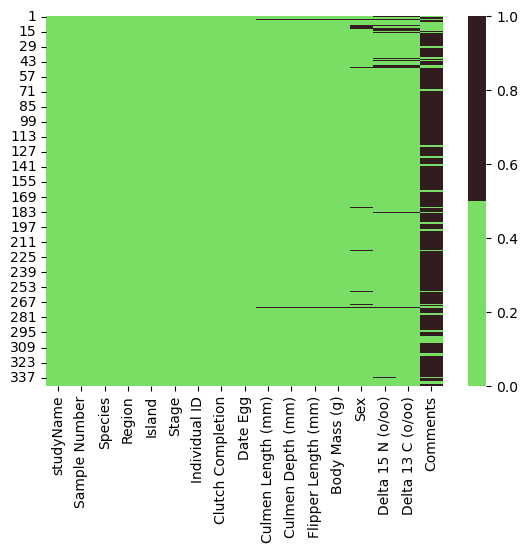

In [6]:
colours = ['#79de64', '#311d20'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

Let's calculate as a percentage how many gaps we have in the columns.

In [7]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

studyName - 0%
Sample Number - 0%
Species - 0%
Region - 0%
Island - 0%
Stage - 0%
Individual ID - 0%
Clutch Completion - 0%
Date Egg - 0%
Culmen Length (mm) - 1%
Culmen Depth (mm) - 1%
Flipper Length (mm) - 1%
Body Mass (g) - 1%
Sex - 3%
Delta 15 N (o/oo) - 4%
Delta 13 C (o/oo) - 4%
Comments - 84%


Let's take a look at exactly what values are contained in the "Comments" column

In [8]:
df['Comments'].unique()

array(['Not enough blood for isotopes.', nan, 'Adult not sampled.',
       'Nest never observed with full clutch.',
       'No blood sample obtained.',
       'No blood sample obtained for sexing.',
       'Nest never observed with full clutch. Not enough blood for isotopes.',
       'Sexing primers did not amplify. Not enough blood for isotopes.',
       'Sexing primers did not amplify.',
       'Adult not sampled. Nest never observed with full clutch.',
       'No delta15N data received from lab.'], dtype=object)

For ornithologists, this information is certainly important, but not for us (data scientist). Delete it.

In [9]:
df = df.drop(['Comments'], axis=1)

In [10]:
df.nunique()

studyName                3
Sample Number          152
Species                  3
Region                   1
Island                   3
Stage                    1
Individual ID          190
Clutch Completion        2
Date Egg                50
Culmen Length (mm)     164
Culmen Depth (mm)       80
Flipper Length (mm)     55
Body Mass (g)           94
Sex                      2
Delta 15 N (o/oo)      330
Delta 13 C (o/oo)      331
dtype: int64

Let's see what kinds of penguins we are dealing with.

In [11]:
df['Species'].value_counts()

Adelie Penguin (Pygoscelis adeliae)          152
Gentoo penguin (Pygoscelis papua)            124
Chinstrap penguin (Pygoscelis antarctica)     68
Name: Species, dtype: int64

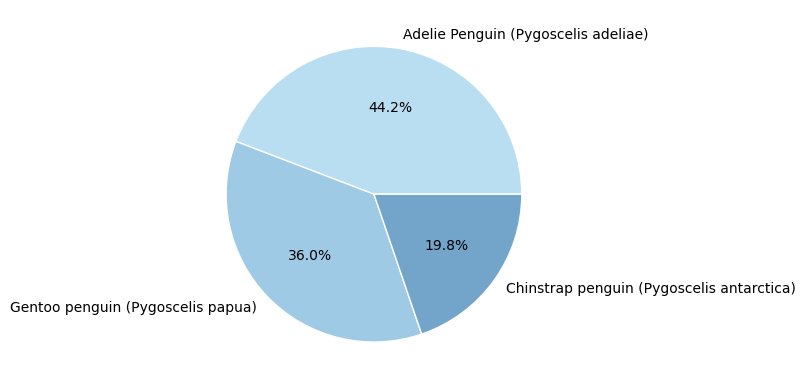

In [12]:
colors = ["#B9DDF1", "#9FCAE6", "#73A4CA", "#497AA7", "#2E5B88"]
labels = df['Species'].value_counts().index
fig, ax = plt.subplots()
ax.pie(df['Species'].value_counts(),labels=labels, colors = colors, autopct = '%1.1f%%',
      wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.show()

What islands do they live on?

In [13]:
df['Island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: Island, dtype: int64

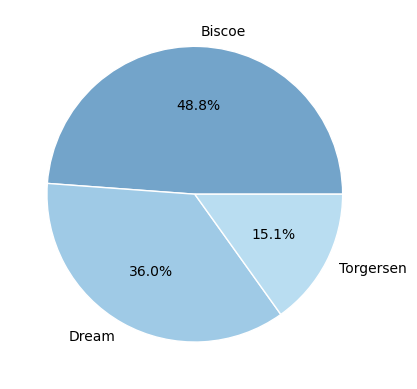

In [14]:
colors = ["#73A4CA", "#9FCAE6","#B9DDF1", "#9FCAE6", "#73A4CA"]
labels = df['Island'].value_counts().index
fig, ax = plt.subplots()
ax.pie(df['Island'].value_counts(),labels=labels, colors = colors, autopct = '%1.1f%%',
      wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.show()

To solve the classification problem and build a machine learning model, we leave the following set of columns.

In [15]:
df = df[['Species', 'Island', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex']]

To begin with, we binarize the column with selection by gender.

In [16]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'MALE' else 0)

In [17]:
df.sample(5)

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
95,Adelie Penguin (Pygoscelis adeliae),Dream,36.2,17.3,187.0,3300.0,0
84,Adelie Penguin (Pygoscelis adeliae),Torgersen,35.1,19.4,193.0,4200.0,1
152,Adelie Penguin (Pygoscelis adeliae),Dream,41.5,18.5,201.0,4000.0,1
153,Gentoo penguin (Pygoscelis papua),Biscoe,46.1,13.2,211.0,4500.0,0
334,Chinstrap penguin (Pygoscelis antarctica),Dream,49.3,19.9,203.0,4050.0,1


In [18]:
df['Sex'].value_counts().values

array([176, 168])

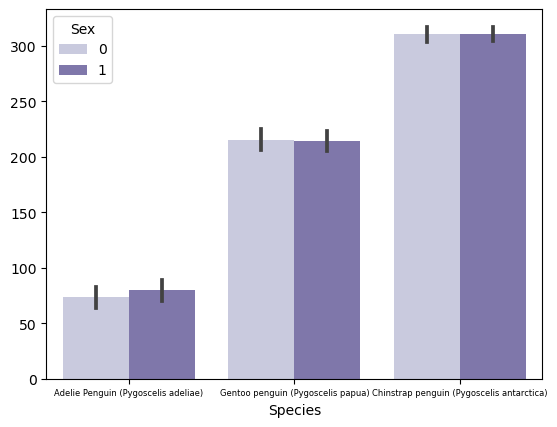

In [19]:
sns.barplot(data=df, x='Species',y=df.Species.index, hue='Sex', palette="Purples")
plt.xticks(fontsize=6)
plt.show()

Let's use Boxplot to see how the body weight is distributed, depending on the type of penguins.

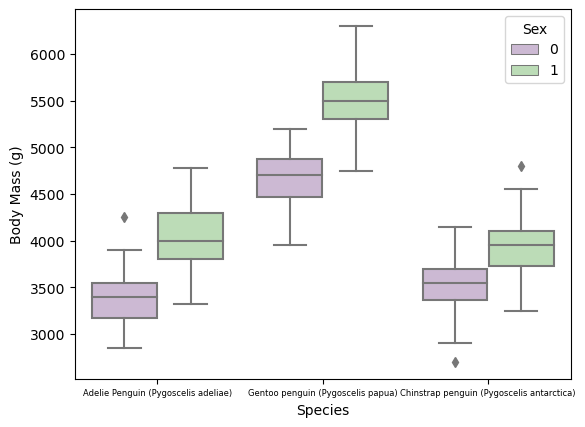

In [20]:
sns.set_context(rc={"font.size":10,"axes.titlesize":8,"axes.labelsize":10})  
sns.boxplot(x=df['Species'], y=df['Body Mass (g)'], hue=df['Sex'], palette="PRGn")
plt.xticks(fontsize=6)
plt.show()

The two species have body mass values that are very different from the population averages. Let's look at them.

In [21]:
df[df['Species']=='Chinstrap penguin (Pygoscelis antarctica)']['Body Mass (g)'].describe()

count      68.000000
mean     3733.088235
std       384.335081
min      2700.000000
25%      3487.500000
50%      3700.000000
75%      3950.000000
max      4800.000000
Name: Body Mass (g), dtype: float64

There are no anomalies in the mass, a large mass is observed in males, most likely they are adults, and too small a mass in young females. The data is fine.

In [22]:
df[(df['Species']=='Chinstrap penguin (Pygoscelis antarctica)') & (df['Body Mass (g)']>=4500)]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
306,Chinstrap penguin (Pygoscelis antarctica),Dream,52.8,20.0,205.0,4550.0,1
314,Chinstrap penguin (Pygoscelis antarctica),Dream,52.0,20.7,210.0,4800.0,1
316,Chinstrap penguin (Pygoscelis antarctica),Dream,53.5,19.9,205.0,4500.0,1


In [23]:
df[(df['Species']=='Chinstrap penguin (Pygoscelis antarctica)') & (df['Body Mass (g)']<3000)]

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex
299,Chinstrap penguin (Pygoscelis antarctica),Dream,43.2,16.6,187.0,2900.0,0
315,Chinstrap penguin (Pygoscelis antarctica),Dream,46.9,16.6,192.0,2700.0,0


And where are the islands inhabited by penguins? Having received the names from our data, enriching them with geographical coordinates (latitude and longitude) from Wikipedia and visualizing them using the scatter_mapbox tool.

In [24]:
df['Island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [25]:
island = {'Location': ['Torgersen', 'Biscoe', 'Dream'], 'Latitude': [-64.766667, -65.433333, -64.733333], 'Longitude': [-64.083333,-65.5, -64.233333]} 
df_island = pd.DataFrame(island)

In [26]:
df_island.head()

,Location,Latitude,Longitude
0,Torgersen,-64.766667,-64.083333
1,Biscoe,-65.433333,-65.500000
2,Dream,-64.733333,-64.233333


Swimming in waters where the Antarctic circumpolar current (the current of Western Winds) is perhaps one of the worst places on our planet for humans, but penguins  like it there))))

In [27]:
fig = px.scatter_mapbox(df_island, lat = 'Latitude', lon = 'Longitude', text = 'Location',
                                                zoom = 4, mapbox_style = 'open-street-map')                      
fig.show() 

In order for our model to be able to learn, it is necessary to assign categorical values to the Species column.

In [28]:
df['Species'] = df['Species'].astype('category')

In [29]:
df.dtypes

Species                category
Island                   object
Culmen Length (mm)      float64
Culmen Depth (mm)       float64
Flipper Length (mm)     float64
Body Mass (g)           float64
Sex                       int64
dtype: object

In [30]:
df['Species_category'] = df['Species'].cat.codes

We will do the same with the Island column.

In [31]:
df['Island'] = df['Island'].astype('category')
df['Island_category'] = df['Island'].cat.codes

In [32]:
df.sample(5)

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Species_category,Island_category
65,Adelie Penguin (Pygoscelis adeliae),Biscoe,36.4,17.1,184.0,2850.0,0,0,0
208,Gentoo penguin (Pygoscelis papua),Biscoe,45.0,15.4,220.0,5050.0,1,2,0
120,Adelie Penguin (Pygoscelis adeliae),Torgersen,41.1,18.6,189.0,3325.0,1,0,2
243,Gentoo penguin (Pygoscelis papua),Biscoe,47.5,15.0,218.0,4950.0,0,2,0
162,Gentoo penguin (Pygoscelis papua),Biscoe,46.8,15.4,215.0,5150.0,1,2,0


In our dataframe, we will leave only numeric and categorical values. Let's build a correlation matrix.

In [33]:
df = df[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex', 'Species_category', 'Island_category']]

<Axes: >

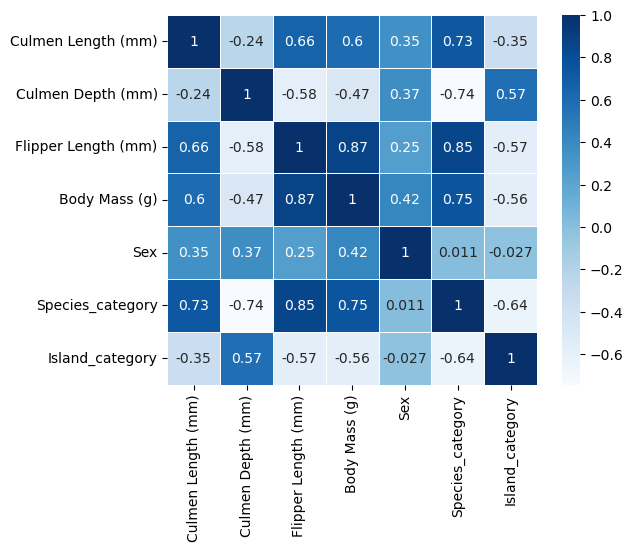

In [34]:
sns.heatmap(df.corr(), annot=True, square=True, linewidths=0.5, linecolor='white', cmap='Blues')

Using the pairplot method, let's take a look at how the values are distributed, whether it is possible to visually distinguish individual groups / species

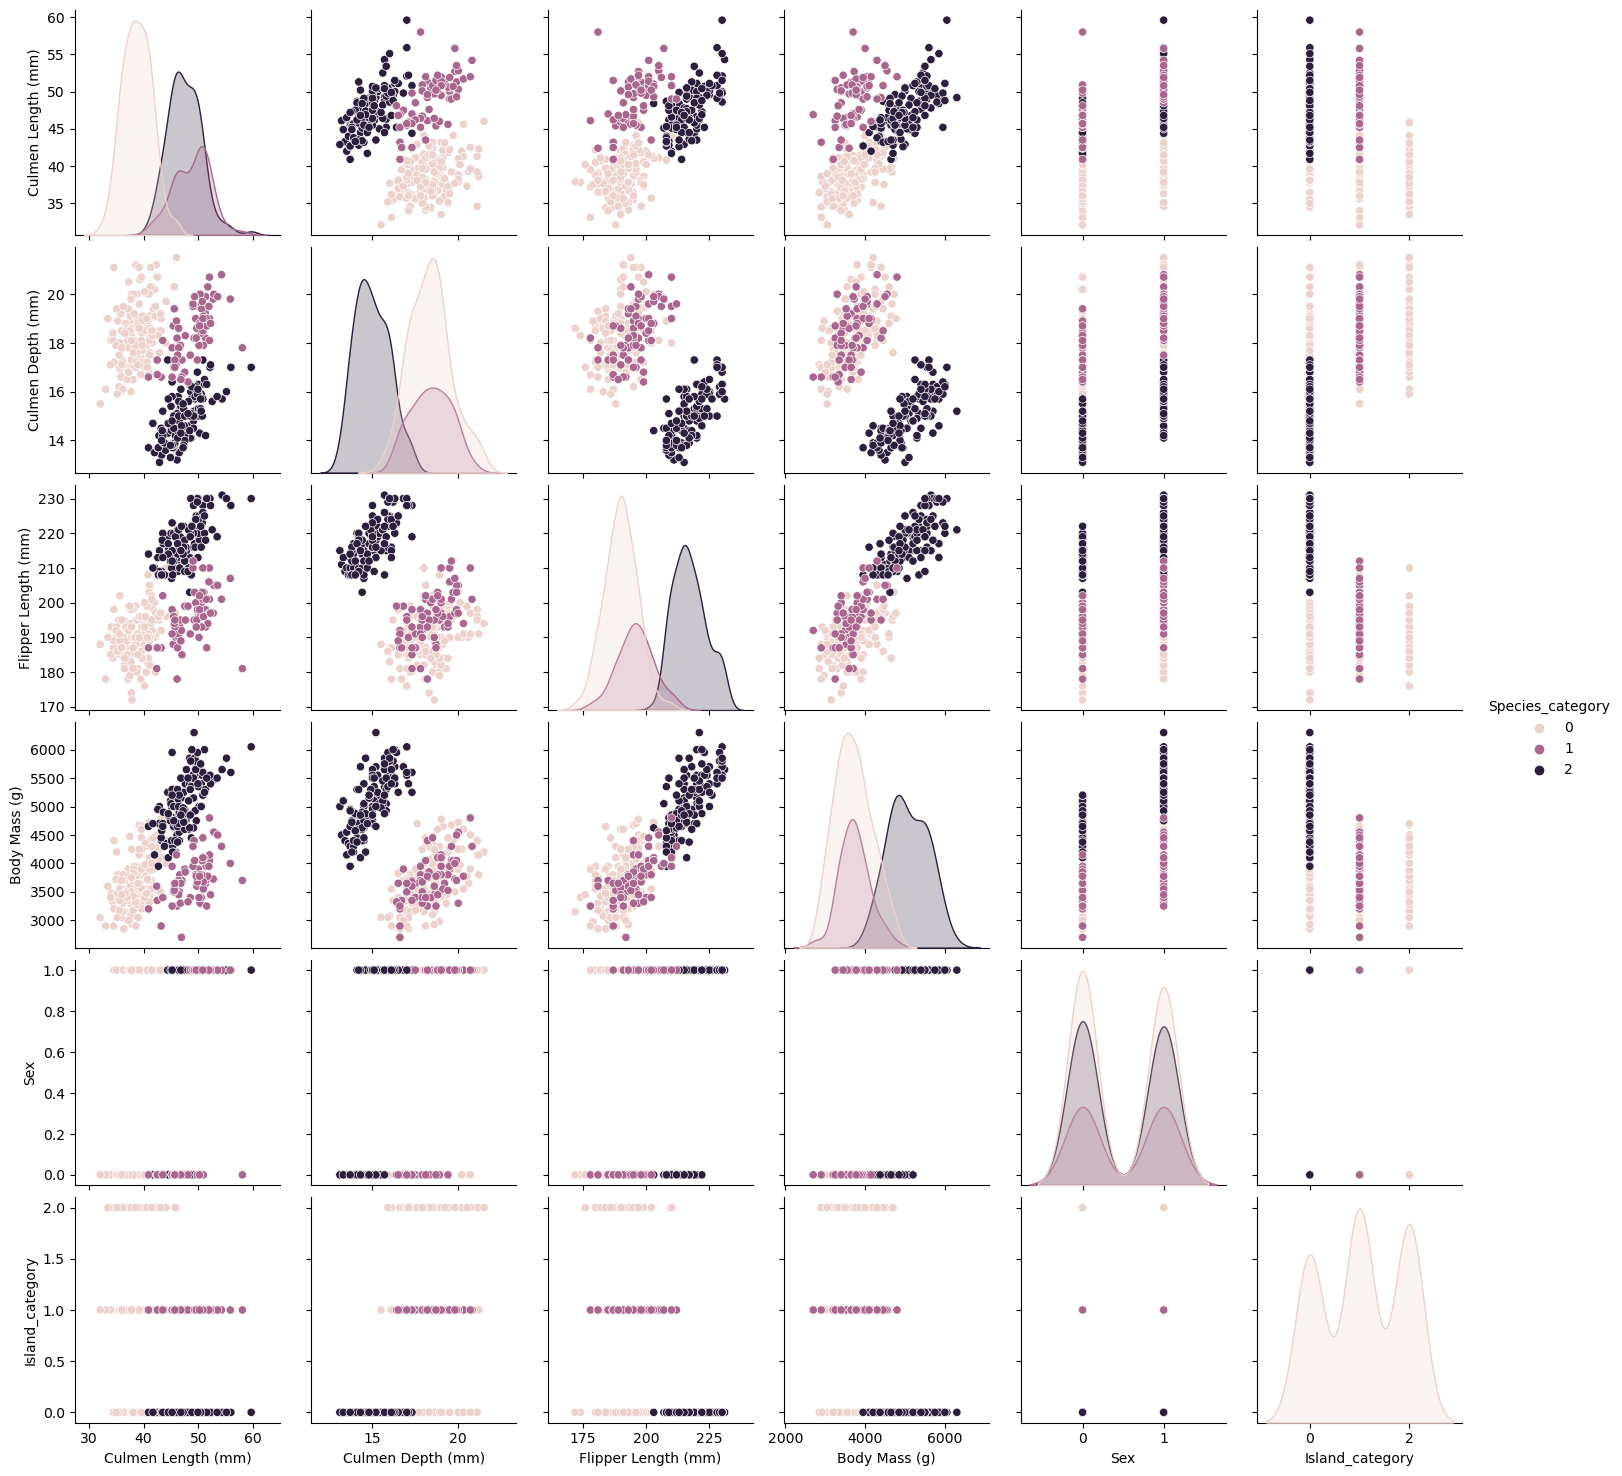

In [35]:
sns.pairplot(df, hue='Species_category')

Adelie Penguin (Pygoscelis adeliae)          0
Chinstrap penguin (Pygoscelis antarctica)    1
Gentoo penguin (Pygoscelis papua)            2

What conclusions can be drawn:
* Gentoo penguin is the largest.
* The habitats of Chinstrap penguin and Gentoo penguin do not overlap, but Adelie Penguin live together with each of the species, neighbors on the island, so to speak.

I will not describe the differences in flippers and bills, this can be seen on the graphs.

In [36]:
df[df['Island_category']==2]['Species_category'].value_counts()

0    52
Name: Species_category, dtype: int64

In [37]:
df[df['Island_category']==1]['Species_category'].value_counts() 

1    68
0    56
Name: Species_category, dtype: int64

In [38]:
df[df['Island_category']==0]['Species_category'].value_counts() 

2    124
0     44
Name: Species_category, dtype: int64

Delete the missing values, only 2 lines in total.

In [39]:
df = df.dropna()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 1 to 344
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Culmen Length (mm)   342 non-null    float64
 1   Culmen Depth (mm)    342 non-null    float64
 2   Flipper Length (mm)  342 non-null    float64
 3   Body Mass (g)        342 non-null    float64
 4   Sex                  342 non-null    int64  
 5   Species_category     342 non-null    int8   
 6   Island_category      342 non-null    int8   
dtypes: float64(4), int64(1), int8(2)
memory usage: 16.7 KB


Let's start building the model. For this classification task we will use Linear Discriminant Analysis

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import accuracy_score

The value we will predict is Species_category

In [42]:
y = df['Species_category']
X = df.drop('Species_category',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
print(y_test.unique())
Counter(y_train)

[0 1 2]


Counter({0: 115, 2: 103, 1: 55})

In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [45]:
lda = LinearDiscriminantAnalysis()

In [46]:
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [47]:
lda.predict(X_test)

array([0, 1, 0, 1, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 0,
       1, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 1, 2, 1, 0, 0, 0, 0, 2,
       0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       0, 2, 0], dtype=int8)

The model coped with the task perfectly, accuracy is 100%.

In [48]:
print (f"Accuracy: {accuracy_score(y_test, lda.predict(X_test))}")
print (classification_report(y_test, lda.predict(X_test)))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        20

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [49]:
model_matrix = confusion_matrix(y_test, lda.predict(X_test), labels = [0,1,2])

In [50]:
model_matrix_df = pd.DataFrame(model_matrix)
model_matrix_df

,0,1,2
0,36,0,0
1,0,13,0
2,0,0,20
